# Visualization DriveLM

In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="0" 
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import re

In [23]:
origin_path = "/APP/DriveLM/challenge/test_eval.json"
result_path = "/APP/DriveLM/challenge/test_output.json"

with open(result_path, 'r') as file:
    pred_file = json.load(file)
pred_file = {pred_file[i]["id"]: pred_file[i] for i in range(len(pred_file))}

with open(origin_path, 'r') as file:
    test_file = json.load(file)
 

In [24]:
for scene_id in test_file.keys():
    scene_data = test_file[scene_id]['key_frames']
    for frame_id in scene_data.keys():
        print("scene_id:{}, frame_id:{}".format(scene_id, frame_id))

scene_id:f0f120e4d4b0441da90ec53b16ee169d, frame_id:4a0798f849ca477ab18009c3a20b7df2
scene_id:f0f120e4d4b0441da90ec53b16ee169d, frame_id:ffd1bdf020d145759224c629b501d2b2
scene_id:f0f120e4d4b0441da90ec53b16ee169d, frame_id:d9075c2a5f864a2b8abf41e703f4cf1c
scene_id:f0f120e4d4b0441da90ec53b16ee169d, frame_id:dfb8d8959b9944d69dcec6d05e419f04
scene_id:54cdaaae372d421fa4734d66f51a8c48, frame_id:542eaf1fc9b34895a9e55fab57cb4cf4
scene_id:54cdaaae372d421fa4734d66f51a8c48, frame_id:1b45a97a0e5e49fe9cd345dd4bd729c3
scene_id:54cdaaae372d421fa4734d66f51a8c48, frame_id:d5e16062410f4e329d31a881b28e5c1c
scene_id:54cdaaae372d421fa4734d66f51a8c48, frame_id:7abe79e5d3d745bcb237a4b7e03d1577
scene_id:54cdaaae372d421fa4734d66f51a8c48, frame_id:0dd14c14cea14dc1b0c0c9b0c9c7c4c3


In [25]:
def get_images(pred_file, test_file, scene_id, frame_id, root_dir):
    scene_data = test_file[scene_id]['key_frames']
    frame_qa = scene_data[frame_id]['QA']
    frame_paths = scene_data[frame_id]['image_paths']
    
    perception_num = len(frame_qa["perception"])
    prediction_num = len(frame_qa["prediction"])
    planning_num = len(frame_qa["planning"])
    behavior_num = len(frame_qa["behavior"])
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for ax, (key, path) in zip(axs.flatten(), frame_paths.items()):
        path = path.replace("..", root_dir)
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.set_title(key)  
        ax.axis('off')  

    plt.tight_layout()
    plt.show()
    

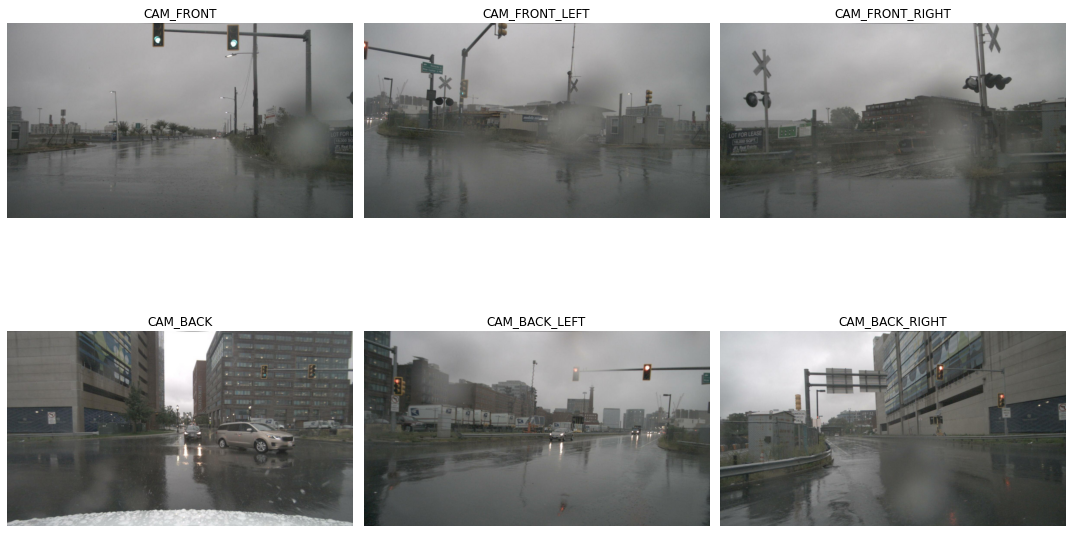

In [26]:
scene_id="f0f120e4d4b0441da90ec53b16ee169d"
frame_id="4a0798f849ca477ab18009c3a20b7df2"
root_dir="/APP/DriveLM/challenge/llama_adapter_v2_multimodal7b/data"
get_images(pred_file, test_file, scene_id, frame_id, root_dir)

In [27]:
def center_matches(matches):
    bbox_data = defaultdict(list)
    for match in matches:
        data_cleaned = match.strip('<>').split(',')
        index = data_cleaned[0]
        cam = data_cleaned[1]
        
        x_2d = int(float(data_cleaned[2]))
        y_2d = int(float(data_cleaned[3]))
        bbox_data[cam].append([index, x_2d, y_2d])
    return bbox_data

def get_result(pred_file, test_file, scene_id, frame_id, root_dir, qa_type="perception"):
    scene_data = test_file[scene_id]['key_frames']
    frame_qa = scene_data[frame_id]['QA']
    frame_paths = scene_data[frame_id]['image_paths']
    
    perception_num = len(frame_qa["perception"])
    prediction_num = len(frame_qa["prediction"])
    planning_num = len(frame_qa["planning"])
    behavior_num = len(frame_qa["behavior"])

    print("======= {} =======".format(qa_type))
    question_matches = []
    GT_matches = []
    predict_matches = []
    for i, qa in enumerate(frame_qa[qa_type]):
        question = qa['Q']
        GT = qa['A']
        tag = qa['tag']
        if qa_type == "perception":
            idx = scene_id + "_" + frame_id + "_" + str(i)
        elif qa_type == "prediction":
            idx = scene_id + "_" + frame_id + "_" + str(i + perception_num)
        elif qa_type == "planning":
            idx = scene_id + "_" + frame_id + "_" + str(i + perception_num + prediction_num)
        elif qa_type == "behavior":
            idx = scene_id + "_" + frame_id + "_" + str(i + perception_num + prediction_num + planning_num)
        else:
            assert("qa_type error")
        
        predict = pred_file[idx]["answer"]
        print('---------')
        print("question:{}".format(question))
        print("GT:{}".format(GT))
        print("predict:{}".format(predict))
        
        question_matches.extend(re.findall(r'<[^>]+>', question))
        GT_matches.extend(re.findall(r'<[^>]+>', GT))
        predict_matches.extend(re.findall(r'<[^>]+>', predict))
        print('---------')
    
    question_matches = list(set(question_matches))
    GT_matches = list(set(GT_matches))
    predict_matches = list(set(predict_matches))
    
    question_bboxes = center_matches(question_matches)
    GT_bboxes = center_matches(GT_matches)
    predict_bboxes = center_matches(predict_matches)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for ax, (key, path) in zip(axs.flatten(), frame_paths.items()):
        path = path.replace("..", root_dir)
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.set_title(key)  
       
        if key in question_bboxes:
            for index, x_2d, y_2d in question_bboxes[key]:
                ax.annotate(index, 
                xy=(x_2d, y_2d),  # 箭头指向的点
                xytext=(x_2d, y_2d),
                color='black', 
                fontsize=20,# 文本的起始位置
                bbox=dict(facecolor='black', alpha=0.5),
                arrowprops=dict(facecolor='black', shrink=0.02))
        
        if key in GT_bboxes:
            for index, x_2d, y_2d in GT_bboxes[key]:
                ax.annotate(index, 
                xy=(x_2d, y_2d),  # 箭头指向的点
                xytext=(x_2d, y_2d),
                color='lightgoldenrodyellow', 
                fontsize=20,# 文本的起始位置
                bbox=dict(facecolor='lightgoldenrodyellow', alpha=0.5),
                arrowprops=dict(facecolor='lightgoldenrodyellow', shrink=0.02))
        
        if key in predict_bboxes:
            for index, x_2d, y_2d in predict_bboxes[key]:
                ax.annotate(index, 
                xy=(x_2d, y_2d),  # 箭头指向的点
                xytext=(x_2d, y_2d),
                color='powderblue', 
                fontsize=20,# 文本的起始位置
                bbox=dict(facecolor='powderblue', alpha=0.5),
                arrowprops=dict(facecolor='powderblue', shrink=0.02))
            
        ax.axis('off')  

    plt.tight_layout()
    plt.show()

======= perception =======
---------
question:What are the important objects in the current scene? Those objects will be considered for the future reasoning and driving decision.
GT:There is a brown SUV to the back of the ego vehicle, a black sedan to the back of the ego vehicle, and a green light to the front of the ego vehicle. The IDs of these objects are <c1,CAM_BACK,1088.3,497.5>, <c2,CAM_BACK,864.2,468.3>, and <c3,CAM_FRONT,1043.2,82.2>.
predict:There is a black sedan to the front of the ego vehicle, a black sedan to the back of the ego vehicle, a black sedan to the front of the ego vehicle, and a black sedan to the back of the ego vehicle. The IDs of these objects are <c1,CAM_FRONT,581.5,502.5>, <c2,CAM_BACK,1000.0,502.5>, <c3,CAM_FRONT,1000.0,502.5>, and <c4,CAM_BACK,1000.0,502.5>.
---------
---------
question:What is the moving status of object <c1,CAM_BACK,1088.3,497.5>? Please select the correct answer from the following options: A. Going ahead. B. Stopped. C. Back up. D. Tu

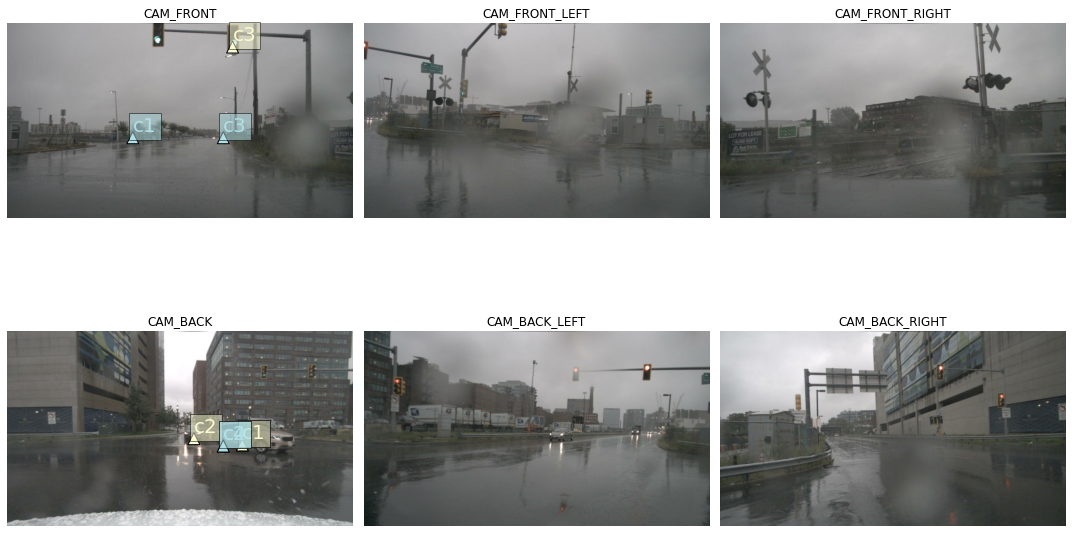

In [28]:
get_result(pred_file, test_file, scene_id, frame_id, root_dir, qa_type="perception")

======= prediction =======
---------
question:What object should the ego vehicle notice first when the ego vehicle is getting to the next possible location? What is the state of the object that is first noticed by the ego vehicle and what action should the ego vehicle take? What object should the ego vehicle notice second when the ego vehicle is getting to the next possible location? What is the state of the object perceived by the ego vehicle as second and what action should the ego vehicle take? What object should the ego vehicle notice third? What is the state of the object perceived by the ego vehicle as third and what action should the ego vehicle take?
GT:Firstly notice that <c3,CAM_FRONT,1043.2,82.2>. The object is a traffic sign, so the ego vehicle should keep going ahead at the same speed. Secondly notice that <c1,CAM_BACK,1088.3,497.5>. The object is turning left, so the ego vehicle should keep going ahead at the same speed. Thirdly notice that <c2,CAM_BACK,864.2,468.3>. The 

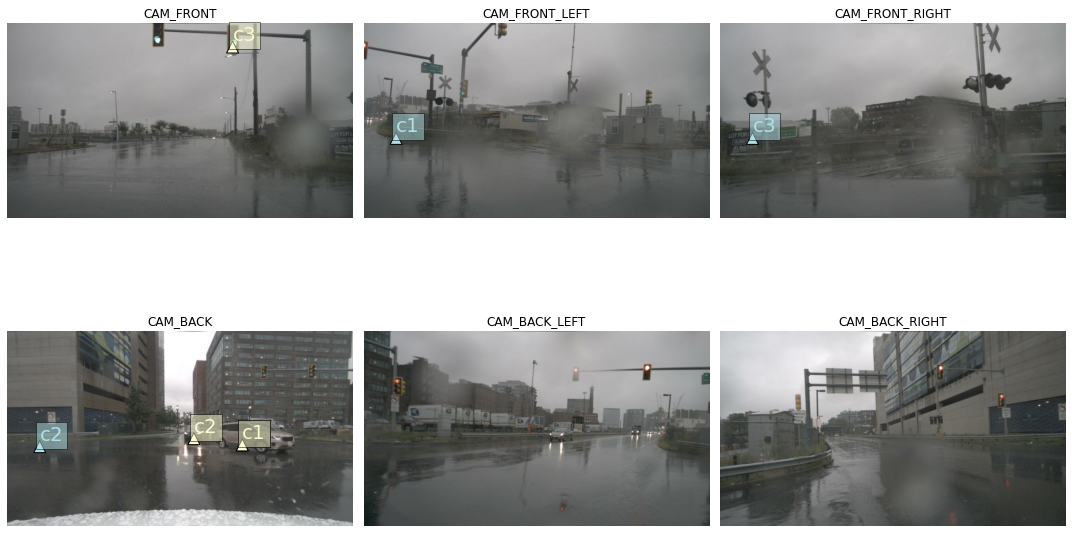

In [29]:
get_result(pred_file, test_file, scene_id, frame_id, root_dir, qa_type="prediction")

======= planning =======
---------
question:What actions could the ego vehicle take based on <c1,CAM_BACK,1088.3,497.5>? Why take this action and what's the probability?
GT:The action is to keep going at the same speed. The reason is to follow the traffic rules, which has a high probability.
predict:The action is to keep going at the same speed. The reason is that there is no safety issue, and the probability is high.
---------
---------
question:What actions taken by the ego vehicle can lead to a collision with <c1,CAM_BACK,1088.3,497.5>?
GT:No such action will lead to a collision.
predict:Back up.
---------
---------
question:In this scenario, what are safe actions to take for the ego vehicle?
GT:Keep going at the same speed, decelerate gradually without braking.
predict:Keep going at the same speed, decelerate gradually without braking.
---------


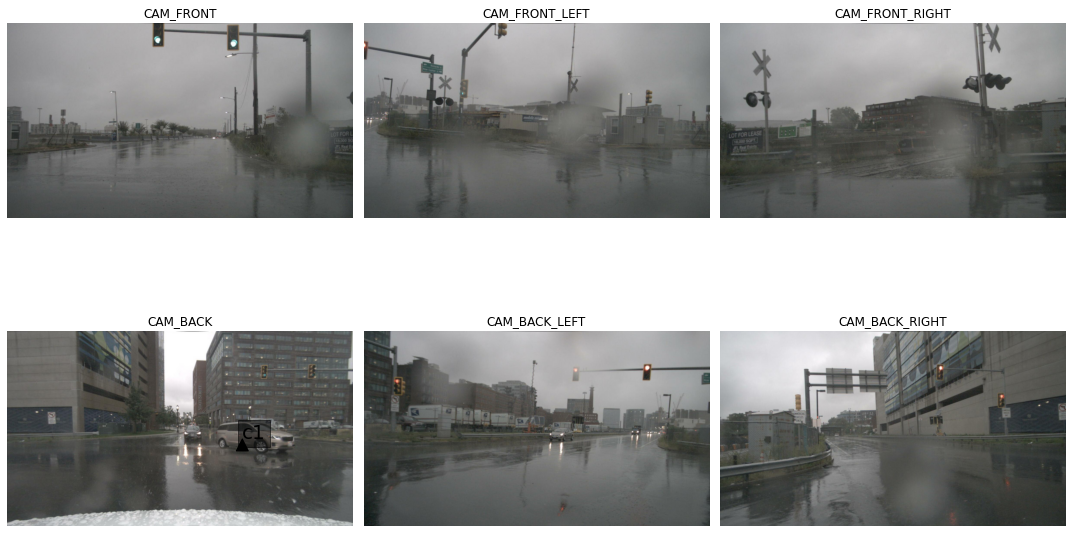

In [31]:
get_result(pred_file, test_file, scene_id, frame_id, root_dir, qa_type="planning")

======= behavior =======
---------
question:Predict the behavior of the ego vehicle. Please select the correct answer from the following options: A. The ego vehicle is slightly steering to the left. The ego vehicle is driving fast. B. The ego vehicle is going straight. The ego vehicle is driving fast. C. The ego vehicle is slightly steering to the left. The ego vehicle is driving with normal speed. D. The ego vehicle is going straight. The ego vehicle is driving with normal speed.
GT:B
predict:B
---------


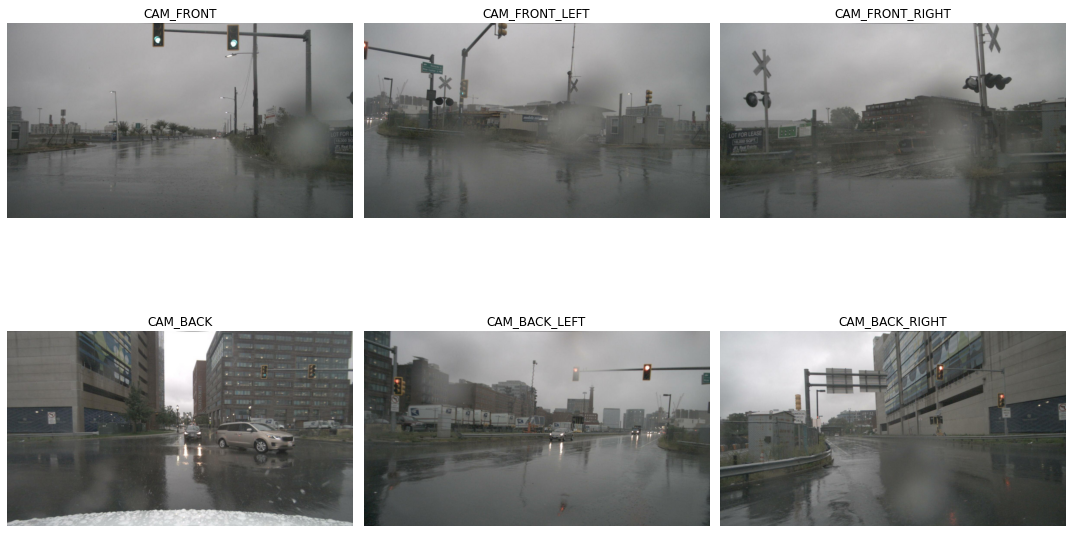

In [32]:
get_result(pred_file, test_file, scene_id, frame_id, root_dir, qa_type="behavior")